### Notebook to test out vortex tracking from WRF TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
June 2022

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import sys
import cartopy
# from smooth_runn_mn import smooth_runn_mn
from scipy import ndimage
from relvort import relvort
# from object_track import object_track
from mask_tc_track import mask_tc_track
# import cmocean
# from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
# from stratiform_index import stratiform_index

In [ ]:
x=['s']
print(x*6)

ssssss


#### Directories

In [2]:
# figdir = "/Users/jruppert/code/tc_figs/"
# main = "/Users/jruppert/code/tc_output/"

# figdir = "/Users/jamesruppert/code/git/tc_figs/"
# main = "/Users/jamesruppert/code/tc_output/"
# main+= 'haiyan'

figdir = "/home/jamesrup/figures/tc/ens/"
# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

storm = !ls $main

test='ctl'
# test='ncrf'

# print(storm)

istorm = 'haiyan'
istorm = 'maria'
# istorm=storm[1]

memb = !ls $main/$istorm
imemb=memb[7]
print(main+istorm+'/'+imemb)

datdir = main+istorm+'/'+imemb+'/'+test+'/'
datdir += 'post/d02/'
print(datdir)

/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/maria/memb_08
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/maria/memb_08/ctl/post/d02/


#### Read variables

In [3]:
# LonLat
# fil = Dataset(datdir+'../../LATLON.nc') # this opens the netcdf file
# fil = Dataset(datdir+'../../wrfout_d02_2013-11-03_00:00:00') # this opens the netcdf file
fil = Dataset(datdir+'../../wrfout_d02_2017-09-16_00:00:00') # this opens the netcdf file
lon = fil.variables['XLONG'][:][0] # deg
lon1d=lon[0,:]
lat = fil.variables['XLAT'][:][0] # deg
lat1d=lat[:,0]
fil.close()
llshape=np.shape(lon)
nx = llshape[1]
ny = llshape[0]

# Pressure
fil = Dataset(datdir+'AVOR.nc') # this opens the netcdf file
pres = fil.variables['pres'][:] # hPa
fil.close()
# nz = np.shape(pres)[0]

In [4]:
# Level selection
ptrack=600 # tracking pressure level
ikread = np.where(pres == ptrack)[0][0]
print('Tracking at:',round(pres[ikread]),'hPa')

Tracking at: 600 hPa


In [5]:
# Horizontal wind
ufil = Dataset(datdir+'U.nc') # this opens the netcdf file
u = ufil.variables['U'][:,ikread,:,:] # m/s
ufil.close()
vfil = Dataset(datdir+'V.nc') # this opens the netcdf file
v = vfil.variables['V'][:,ikread,:,:] # m/s
vfil.close()
fil = Dataset(datdir+'AVOR.nc') # this opens the netcdf file
vor = fil.variables['AVOR'][:,ikread,:,:] # 10**-5 /s
fil.close()

rfil = Dataset(datdir+'rainrate.nc') # this opens the netcdf file
rain = rfil.variables['rainrate'][:,0,:,:] # mm/hr
rfil.close()

nt=np.shape(vor)[0]

#### Calculate relative vorticity

$\zeta=\hat k \cdot \nabla \times \vec{U} = \dfrac{\partial v}{\partial x} - \dfrac{\partial u}{\partial y}$

For spherical: $\dfrac{\partial}{\partial y} \rightarrow \dfrac{\partial}{a\partial \Phi}$ and $\dfrac{\partial}{ \partial x} \rightarrow \dfrac{\partial}{a \text{cos}(\Phi) \partial \lambda}$, where $\lambda$ is longitude, $a$ is Earth radius, and $\Phi$ is latitude.

#### Conduct tracking

In [6]:
def track_local(f, lon, lat):

    shape=np.shape(f)
    nt,ny,nx = shape

    if len(shape) != 3:
        print("Check input dimensions!")
        print("Shape: ",shape)
        sys.exit()

    #############################################

    # SETTINGS

    nx_sm=9      # Following Chavas 2013 (XX smoothing run x30 times)
    nx_repeat=15 # Run x-smoothing n-times
    nt_smooth=3  # Time-step smoothing
    # nt_repeat=3  # Run time-smoothing n-times
    r_max=5      # Masked out beyond this radius [degrees] at adjacent time steps
                 # Also used to determine buffer from boundaries

    # 3-dimensional lon/lat for weighting
    lon3d = np.repeat(lon[np.newaxis,:,:], nt, axis=0)
    lat3d = np.repeat(lat[np.newaxis,:,:], nt, axis=0)

    #############################################

    # SMOOTHING

    # Smooth input variable in x,y
    f_smooth = ndimage.uniform_filter(f,size=(0,nx_sm,nx_sm),mode='nearest')
    for ido in range(nx_repeat-1):
        f_smooth = ndimage.uniform_filter(f_smooth,size=(0,nx_sm,nx_sm),mode='nearest')

    # Smooth input variable in time
    # for ido in range(nt_repeat):
    f_smooth = ndimage.uniform_filter(f_smooth,size=(nt_smooth,0,0),mode='nearest')

    # BULK MASKING

    # Mask out values < 3 sigma
    f_sigma = f_smooth / np.std(f_smooth)
    f_masked = np.ma.array(f_sigma)
    f_masked = np.ma.masked_where(np.abs(f_masked) < 3, f_masked, copy=False)

    # Mask out first time step
    # f_masked[0,:,:] = np.nan
    # f_masked = np.ma.masked_invalid(f_masked, copy=False)

    # Mask out data within 0.5*r_max from boundaries
    f_masked = np.ma.masked_where(lon3d <= lon[0,0]   +0.5*r_max, f_masked, copy=False)
    f_masked = np.ma.masked_where(lon3d >= lon[0,nx-1]-0.5*r_max, f_masked, copy=False)
    f_masked = np.ma.masked_where(lat3d <= lat[0,0]   +0.5*r_max, f_masked, copy=False)
    f_masked = np.ma.masked_where(lat3d >= lat[ny-1,0]-0.5*r_max, f_masked, copy=False)

    #############################################

    # MASK BEYOND SPECIFIED RADIUS STARTING FROM ALL-TIME MAX

    # Locate the all-time maximum value
    fmax = np.max(f_masked)
    mloc=np.where(f_masked == fmax)
    itmax = mloc[0][0]
    xmax=mloc[2][0]
    ymax=mloc[1][0]

    radius = np.sqrt( (lon-lon[ymax,xmax])**2 + (lat-lat[ymax,xmax])**2 )

    # Mask surrounding points
    for it in range(itmax-1,np.minimum(itmax+1,nt-1)+1):
        f_masked[it,:,:] = np.ma.masked_where(radius > r_max, f_masked[it,:,:], copy=False)

    # Iterate downward from itmax
    for it in range(itmax-1,0,-1):

        fmax = np.max(f_masked[it,:,:])
        mloc = np.where(f_masked[it,:,:] == fmax)
        xmax = mloc[1][0]
        ymax = mloc[0][0]
        
        radius = np.sqrt( (lon-lon[ymax,xmax])**2 + (lat-lat[ymax,xmax])**2 )
        f_masked[it-1,:,:] = np.ma.masked_where(radius > r_max, f_masked[it-1,:,:], copy=False)

    # Iterate upward from itmax
    for it in range(itmax+1,nt-1):

        fmax = np.max(f_masked[it,:,:])
        mloc = np.where(f_masked[it,:,:] == fmax)
        xmax = mloc[1][0]
        ymax = mloc[0][0]

        radius = np.sqrt( (lon-lon[ymax,xmax])**2 + (lat-lat[ymax,xmax])**2 )
        f_masked[it+1,:,:] = np.ma.masked_where(radius > r_max, f_masked[it+1,:,:], copy=False)

    #############################################

    # TRACKING

    # Track maxima in time as the centroid
    clon = np.average(lon3d,axis=(1,2),weights=f_masked)
    clat = np.average(lat3d,axis=(1,2),weights=f_masked)

    track = np.ma.concatenate([clon[np.newaxis,:],clat[np.newaxis,:]])

    return track, f_masked

In [7]:
# Function to account for crossing of the Intl Date Line
def dateline_lon_shift(lon_in, reverse):
    if reverse == 0:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in < 0)] += 360
    else:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in > 180)] -= 360
    # return lon_in + lon_offset
    return lon_offset

In [8]:
# lon_offset = dateline_lon_shift(lon, reverse=0)

# # track, f_masked = object_track(vor, lon, lat)
# track, f_masked = track_local(vor, lon + lon_offset, lat)
# # track, f_masked = track_local(f_masked, lon, lat)
# clon=track[0,:]
# clat=track[1,:]

# clon_offset = dateline_lon_shift(clon, reverse=1)

#### Read track

In [9]:
var_track='rvor'
track_file = datdir+'../../track_'+var_track+'_600hPa.nc'
ncfile = Dataset(track_file)
clon = ncfile.variables['clon'][:] # deg
clat = ncfile.variables['clat'][:] # deg
ncfile.close()

# Mask wind
rmax=8
u_mask = mask_tc_track(track_file, rmax, u[:,np.newaxis,:,:], lon, lat, 0, nt)
rain_mask = mask_tc_track(track_file, rmax, rain[:,np.newaxis,:,:], lon, lat, 0, nt)

/home/jamesrup/python/jhr-wrf-python/mask_tc_track.py:39: RuntimeWarning: invalid value encountered in sqrt
  radius3d = np.sqrt( lon3d**2 + lat3d**2 )


---
### Plotting routines

In [10]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [11]:
# Account for crossing of Date Line
offset = 180
lon_offset = dateline_lon_shift(lon, reverse=0)
lon_offset_plt = lon + lon_offset
lon_offset_plt -= offset
clon_offset = dateline_lon_shift(clon, reverse=0)
clon_shift = clon + clon_offset
clon_shift -= offset

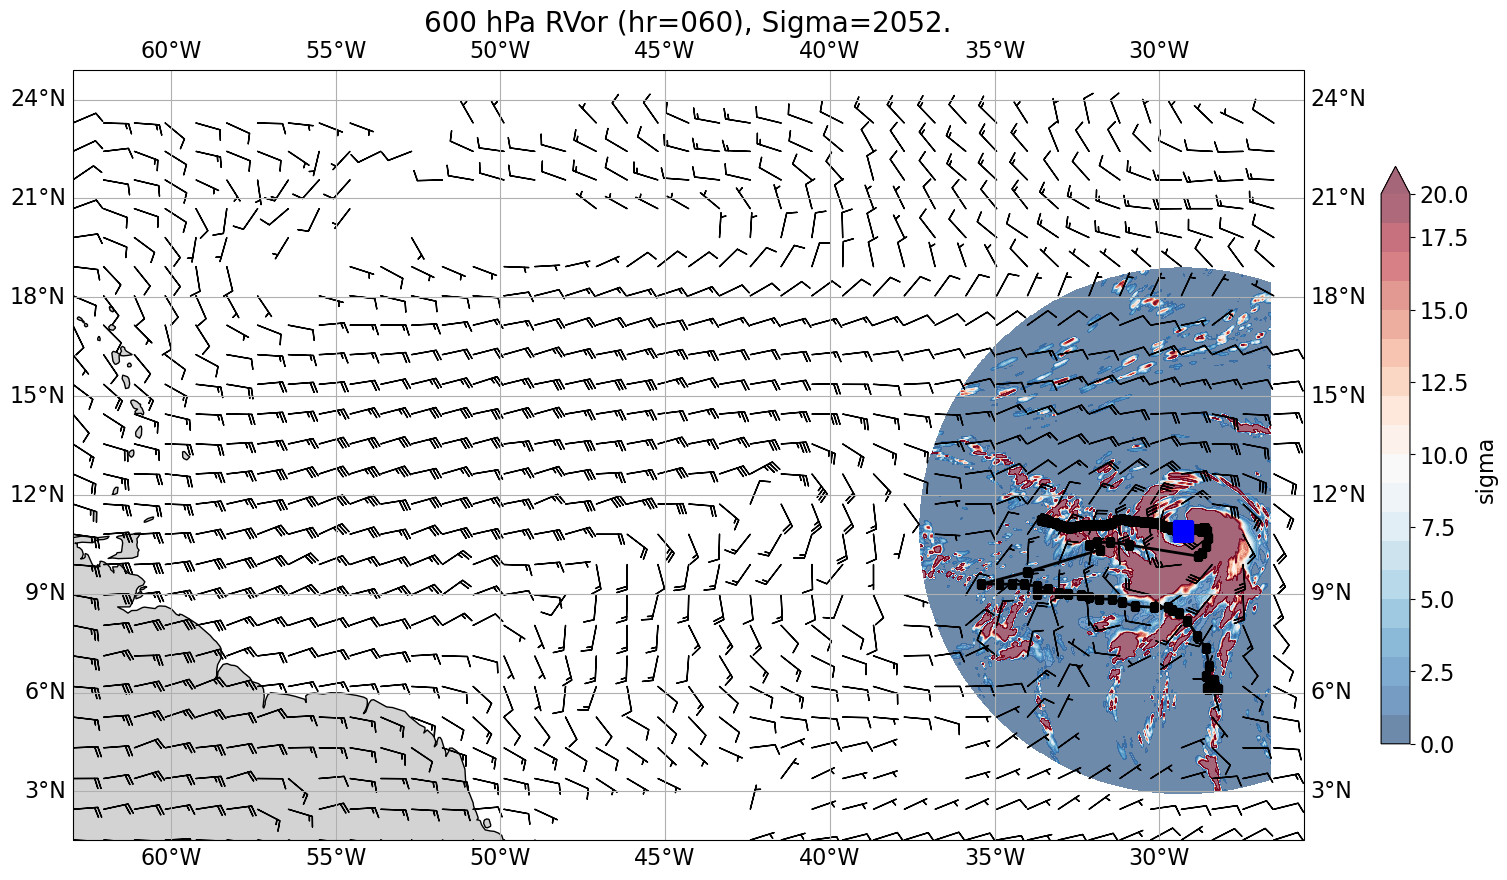

In [12]:
# select plotting area
plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N
# plt_area=[145, np.max(lon), 0, 15] # W,E,S,N

# tsel=36
# for tsel in range(30,65):
for tsel in range(60,61):
# for tsel in range(167,168):
    
    hr_tag = str(np.char.zfill(str(tsel), 3))
    
    iu = u[tsel,:,:]
    iv = v[tsel,:,:]
    # pltvar=f_masked[tsel,:,:]

    # pltvar=u_mask[tsel,0,:,:]
    clevs = np.arange(0.5, 6, 0.5)
    # clevs = np.arange(0.5, 20, 0.5)
    clevs = np.concatenate((-1*np.flip(clevs),clevs))

    pltvar=rain_mask[tsel,0,:,:]
    clevs = np.arange(0, 20, 1)
    
    # sigma=np.std(pltvar)
    sigma=np.max(np.abs(pltvar))
    # print("Sigma = ",sigma)
    # pltvar/=sigma

    # create figure
    fig = plt.figure(figsize=(20,10))
    proj = cartopy.crs.PlateCarree(central_longitude=offset)
    # box_proj = ccrs.PlateCarree(central_longitude=0)
    ax = fig.add_subplot(111,projection=proj)
    ax.set_title(str(round(pres[ikread])) + ' hPa RVor (hr='+hr_tag+'), Sigma='+np.array2string(np.float16(sigma)), fontsize=20)

    # fill contour

    im = ax.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='RdBu_r', alpha=0.6,
                     extend='max', zorder=2)

    cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel('sigma')
            # cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator)

    # wind barbs
    spacing=30#15 #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = iu * mps_to_kts
    vplt = iv * mps_to_kts
    # mask for speeds < 10 kts
    spd = np.sqrt(uplt**2+vplt**2)
    uplt=np.ma.masked_where(spd < 5, uplt, copy=False)

    ax.barbs(lon_offset_plt[::spacing,::spacing], lat[::spacing,::spacing], 
                 uplt[::spacing,::spacing], vplt[::spacing,::spacing], zorder=2, length=6)

    # storm track
    plt.plot(clon_shift, clat, color="black", linewidth=2)
    plt.plot(clon_shift, clat, "s", color="black")
    # current time
    plt.plot(clon_shift[tsel], clat[tsel], "s", color="blue", markersize=15)
    # all-time max (time step 168)
    # plt.plot(lon1d[mloc2[2]], lat1d[mloc2[1]], "s", color="blue", markersize=15)

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    # ax.add_feature(cartopy.feature.OCEAN) #ocean color
    ax.add_feature(cartopy.feature.COASTLINE)
    # ax.add_feature(cartopy.feature.STATES)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Zoom into selected area (comment this out to plot entire available area)
    ax.set_extent(plt_area)

    plt.show()
#     plt.savefig(figdir+'vort'+str(round(pres[ikread]))+'_smx'+str(nx_sm)+'_'+hr_tag+'.png',dpi=200, facecolor='white', \
#               bbox_inches='tight', pad_inches=0.2)
    # plt.close()